In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping


KeyboardInterrupt: 

In [105]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完.csv")
df_test = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完_2022.csv")

In [106]:
df

,time,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,...,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,aqi,truetime,month,hour
0,44927.00,17.9,2.21,0.45,0.13,0.8,14.0,14.9,13.9,30,...,1.9,2.34,285,260,0.8,0.2,28,2023/1/1 00:00,1,0
1,44927.04,17.7,2.18,0.42,0.12,0.6,15.7,16.4,12.4,27,...,1.2,2.30,319,308,0.9,0.2,31,2023/1/1 00:57,1,1
2,44927.08,17.6,2.22,0.46,0.14,0.4,15.0,15.5,11.3,29,...,1.1,2.36,176,159,0.2,0.1,38,2023/1/1 01:55,1,2
3,44927.13,17.2,2.20,0.50,0.14,1.3,17.9,19.2,4.3,36,...,1.1,2.34,136,135,0.7,0.8,44,2023/1/1 03:07,1,3
4,44927.17,17.0,2.22,0.46,0.13,1.1,15.8,17.0,5.7,32,...,0.9,2.35,256,278,1.5,0.6,54,2023/1/1 04:04,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,45291.79,21.7,2.18,0.57,0.08,0.9,20.3,21.3,37.0,52,...,1.3,2.26,338,332,1.7,1.5,70,2023/12/31 18:57,12,19
8756,45291.83,20.9,2.20,0.58,0.08,0.9,20.2,21.1,38.7,52,...,1.4,2.28,337,313,1.6,1.3,79,2023/12/31 19:55,12,20
8757,45291.88,20.3,2.20,0.56,0.07,0.8,19.3,20.1,41.2,53,...,1.4,2.27,348,339,2.0,1.6,86,2023/12/31 21:07,12,21
8758,45291.92,20.0,2.21,0.55,0.06,0.7,18.2,18.9,40.5,42,...,1.5,2.27,9,351,1.2,1.5,93,2023/12/31 22:04,12,22


In [107]:
df_selected = df[['PM10', 'PM2.5','aqi']]#去掉的feature
df_selected_test = df_test[[ 'PM10', 'PM2.5','aqi']]#去掉的feature
sel_data = 'aqi'  

# Train Test split

In [108]:
import math


time_steps = 6
train = df_selected

test = df_selected_test
test

,PM10,PM2.5,aqi
0,41,27,54
1,45,31,60
2,41,28,67
3,42,31,71
4,47,35,75
...,...,...,...
8755,16,11,36
8756,20,10,34
8757,25,9,31
8758,16,10,33


In [109]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))

train_np = scaler.fit_transform(train_temp)
test_np = scaler.transform(test_temp)

In [110]:
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [111]:
print(train_np.shape)

print(test_np)

(8760, 3)
[[0.13898305 0.36486486 0.28571429]
 [0.15254237 0.41891892 0.32298137]
 [0.13898305 0.37837838 0.36645963]
 ...
 [0.08474576 0.12162162 0.14285714]
 [0.05423729 0.13513514 0.1552795 ]
 [0.05084746 0.12162162 0.1242236 ]]


# Train

In [112]:
from tqdm import tqdm
X_train = []
y_train = []

for i in tqdm(range(len(train_np) - time_steps)):
    X_train.append(train_np[i:i+time_steps])
    y_train.append(train_np[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train[0])
print(y_train[0])

100%|██████████| 8754/8754 [00:00<00:00, 1591130.92it/s]

[[0.10169492 0.18918919 0.1242236 ]
 [0.09152542 0.28378378 0.14285714]
 [0.09830508 0.27027027 0.1863354 ]
 [0.1220339  0.36486486 0.22360248]
 [0.10847458 0.37837838 0.28571429]
 [0.08813559 0.27027027 0.32919255]]
[0.11864407 0.37837838 0.32919255]


# Test

In [140]:
x_test = []
y_test = []


for i in tqdm(range(len(test_np)-time_steps)):
    x_test.append(test_np[i:i+time_steps])


y_test= test['aqi']
y_temp = train['aqi']
x_test = np.array(x_test)
y_test = np.array(y_test)
y_temp = np.array(y_temp)

print(x_test[0])
print(y_test.shape)



100%|██████████| 8754/8754 [00:00<00:00, 1356520.38it/s]

[[0.13898305 0.36486486 0.28571429]
 [0.15254237 0.41891892 0.32298137]
 [0.13898305 0.37837838 0.36645963]
 [0.14237288 0.41891892 0.39130435]
 [0.15932203 0.47297297 0.41614907]
 [0.13898305 0.43243243 0.44099379]]
(8760,)


# Model

In [114]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(LSTM(32,return_sequences=True,activation='relu') )
model.add(LSTM(16,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 6, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,795 (30.45 KB)

 Trainable params: 7,795 (30.45 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0303 - val_loss: 0.0207
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.0206
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0030
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 11/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 12/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

# Predict

In [141]:
import random

j =6
num_steps_to_show = 3
initial_sequence = []
initial_sequence.append(test_np[j-time_steps:j])
initial_sequence = np.array(initial_sequence)
print(initial_sequence)


[[[0.13898305 0.36486486 0.28571429]
  [0.15254237 0.41891892 0.32298137]
  [0.13898305 0.37837838 0.36645963]
  [0.14237288 0.41891892 0.39130435]
  [0.15932203 0.47297297 0.41614907]
  [0.13898305 0.43243243 0.44099379]]]


In [142]:
sequence = []
temp = X_train.shape[2]
for i in range(num_steps_to_show):
    new_prediction = model.predict(initial_sequence)

    initial_sequence = initial_sequence[0][1:]
    
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
    sequence.append(new_prediction[0][temp-1])
print(sequence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.4731172, 0.50646996, 0.52764344]


In [148]:
import pickle
sc = MinMaxScaler(feature_range=(0, 1))
y_test= y_test.reshape(-1, 1)
sc.fit(y_test)
with open(r"D:\python_jupty\機器學習作業\model用\scaler2.pkl", 'wb') as f:
    pickle.dump(sc, f)
sequence = sc.inverse_transform(np.array(sequence).reshape(3,1))

In [144]:
sequence=sequence.astype(int)

In [145]:
mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
mse
rmse = np.sqrt(mse)
print('rmse:'   ,rmse)
print('mse:',mse)


rmse: 34.136978971978955
mse: 1165.3333333333333


# 圖

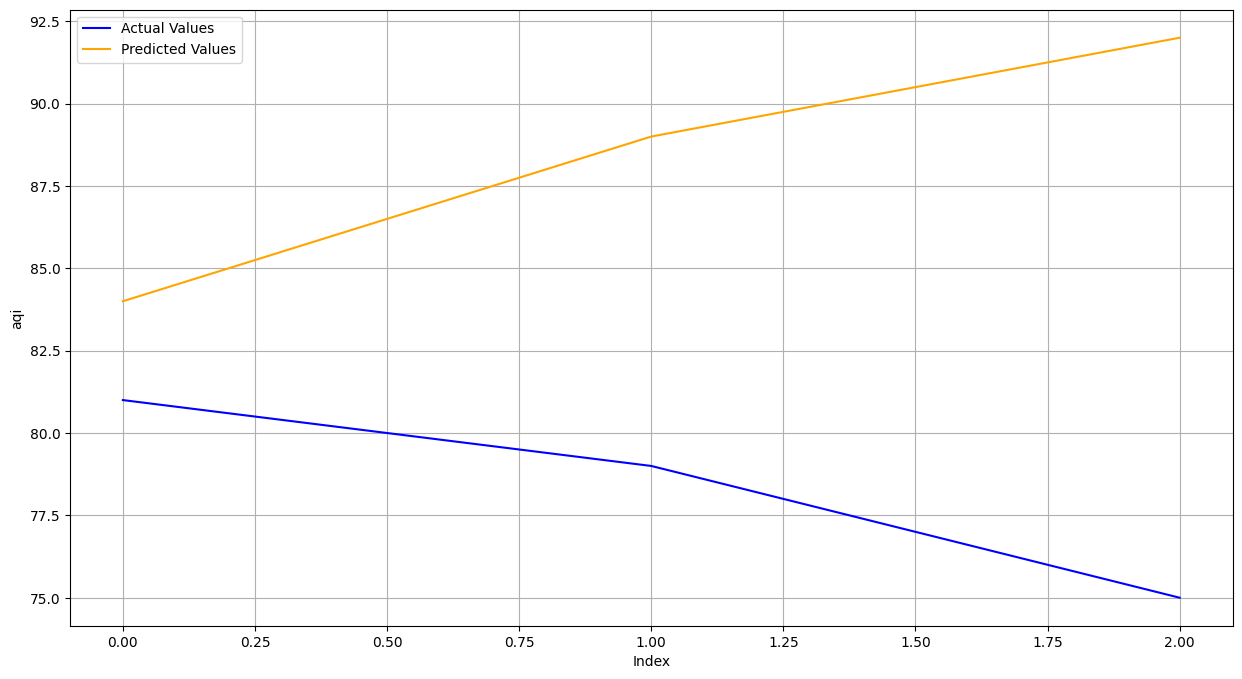

In [146]:

plt.figure(figsize=(15, 8))
plt.plot(y_test[j:j+num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
plt.plot(sequence[:num_steps_to_show], label='Predicted Values', color='orange', linestyle='-')
plt.xlabel('Index')
plt.ylabel('aqi')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
k=0
plt.figure(figsize=(8, 100))
while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
            
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
            sequence.append(new_prediction[0][temp-1])
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        # mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
        # rmse = np.sqrt(mse)
        # print('rmse:',rmse)
        # print('mse:',mse)

        
        plt.subplot(20, 1, k + 1 )
        k=k+1
        plt.plot(y_test[j :j + num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
        plt.plot(sequence, label='Predicted Values', color='orange', linestyle='-')
        plt.title(f'{j}')
  
        plt.xlabel('Index')
        plt.ylabel('AQI')
        plt.ylim(0,150)
        plt.legend() 
        plt.grid(True)
        j=j+24
        if(j>300):
            break
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [133]:
j=6
k=0
total_rmse=0
while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
                   
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])

            sequence.append(new_prediction[0][temp-1])
            if(new_prediction[0][temp-1]>200):
                print(j+i)
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        mse =mean_squared_error(y_test[j:j+num_steps_to_show],sequence)
        rmse = np.sqrt(mse)
        total_rmse+=rmse
        k=k+1
        # print('rmse:',rmse)
        # print('mse:',mse)
        j=j+24
        if(j>8760):
            break
print('rmse:',total_rmse/k)


rmse: 6.3472884055099215


In [134]:
# # model.save("LSTM_RANDOMFOREST_3_rmse87.keras")
# # model.save("LSTM_RANDOMFOREST_4_rmse170.keras")；
# model.save("LSTM_RANDOMFOREST_5_rmse171.keras")
model.save("LSTM_RANDOMFOREST_6_3_rmse62_new.keras")
